# PCA in Python

In [1]:
# Import dstools (absolute path required, please change to your systems settings)
import importlib
import sys

path = '/dstools-master/dstools/__init__.py'
name = 'dstools'

spec = importlib.util.spec_from_file_location(name, path)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from dstools import iris

# Theorie

Die Hauptkomponentenanalyse (PCA) ist ein dimensionsreduzierendes Verfahren. Die hochdimensionalen Daten werden in einen niedriger dimensionalen Raum projiziert, wobei versucht wird, Richtungen (Komponenten) mit maximaler Varianz zu finden. Dadurch kann so viel Information wie möglich erhalten bleiben. Dabei sind folgende Schritte durchzuführen:

1. Daten standardisieren (**nicht** zentrieren!)
1. Kovarianzmatrix berechnen: Die Kovarianzmatrix gibt uns an, wie sich die Variablen in unserem Datensatz zueinander verhalten
1. Eigenwertzerlegung der Kovarianzmatrix: Die Eigenvektoren geben uns die Hauptkomponenten, die Eigenwerte zeigen deren Wichtigkeit an
1. Ursprüngliche Daten in den Raum, der durch die Hauptkomponenten gebildet wird. transformieren


In [3]:
# Load dataset 
# Get X and y as numpy-arrays
# Apply Standard Scaler to X
df = iris()
X, y = df.as_ndarray()
X = StandardScaler().fit_transform(X)

Wir sehen uns nun an, wie man die PCA sowohl mit sklearn als auch händisch berechnen kann.

## Mit sklearn

In [4]:
# Apply PCA
pca = PCA()
princComp = pca.fit_transform(X)

In [5]:
# Build Pandas Dataframe for easy visualisation
# Concat Principal Components with label-vector y
df_raw = pd.DataFrame(data=princComp, columns=['PC1','PC2', 'PC3', 'PC4'])
df = pd.concat([df_raw, pd.Series(y, name='class')], axis=1)
df.head()

,PC1,PC2,PC3,PC4,class
0,-2.264703,0.480027,0.127706,-0.024168,Iris-setosa
1,-2.080961,-0.674134,0.234609,-0.103007,Iris-setosa
2,-2.364229,-0.341908,-0.044201,-0.028377,Iris-setosa
3,-2.299384,-0.597395,-0.091290,0.065956,Iris-setosa
4,-2.389842,0.646835,-0.015738,0.035923,Iris-setosa


In [6]:
# Check explained variance and expained variance ratio
print(pca.explained_variance_, pca.explained_variance_ratio_)

[2.93808505 0.9201649  0.14774182 0.02085386] [0.72962445 0.22850762 0.03668922 0.00517871]


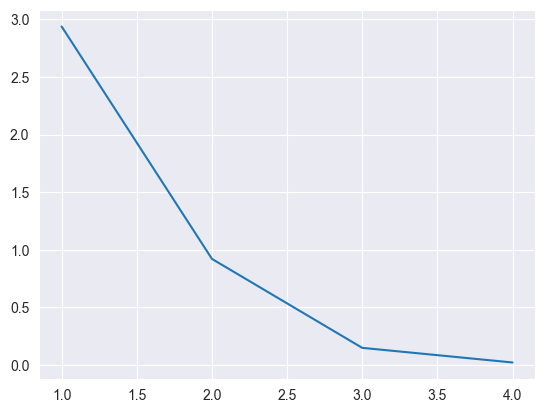

In [7]:
# Screeplot (search for "elbow")
sns.lineplot(x=np.arange(len(pca.explained_variance_))+1, y=pca.explained_variance_);

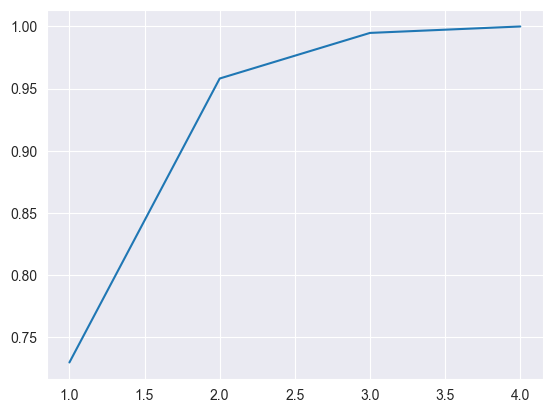

In [8]:
# Variance Graph (minimum number of PCs should explain at least 80% variance)
sns.lineplot(x=np.arange(len(pca.explained_variance_ratio_))+1, y=np.cumsum(pca.explained_variance_ratio_));

Wir sehen, 2 Hauptkomponenten erklären bereits mehr als 95% der Varianz.

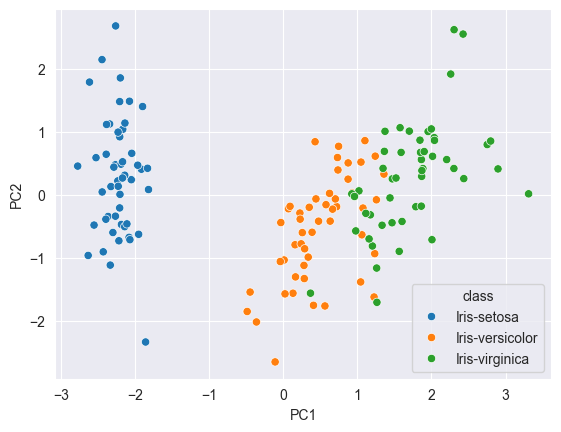

In [9]:
# Plot first 2 principal components
sns.scatterplot(x="PC1", y="PC2", hue="class", data=df);

## Manuelle Berechnung

### Kovarianzmatrix berechnen

Wir bestimmen die Kovarianzmatrix von $X^T$, diese ist symmetrisch und hat identischen Werte auf der Hauptdiagonalen. Zunächst berechnen wir die Kovarianzmatrix mit der `cov`-Funktion aus Numpy, dann zweimal händisch, einmal nach der Formel 

$$
cov(X) = \frac{X^TX}{N-1}
$$

bzw.

$$
cov(x, y) = \frac{1}{N-1} \sum_i (x_i - \bar{x})(y_i - \bar{y})
$$

In [10]:
# Calculate covariance matrix of X-transpose
covmat = np.cov(X.T)
covmat

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

In [11]:
np.dot(X.T, X)/(len(X)-1)

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

In [12]:
def covariance(X, Y):
    """
    Calculate the covariance between two random variables.
    """
    xbar = np.mean(X)
    ybar = np.mean(Y)
    covar = 1 / (len(X) - 1) * np.sum( (X - xbar) * (Y - ybar) )
    return covar

In [13]:
def covariance_matrix(matrix):
    """
    Calculate the variance-covariance matrix.
    """
    n_feat = len(matrix.T)
    C = np.zeros([n_feat, n_feat])
    for ix_1, feature_1 in enumerate(matrix.T):
        for ix_2, feature_2 in enumerate(matrix.T):
            C[ix_1, ix_2] = covariance(feature_1, feature_2)
    return C

In [14]:
covariance_matrix(X)

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

### Eigenwertzerlegung

Die Eigenwerte liefern uns die erklärte Varianz der Hauptkomponenten. Anschließend berechnen wir den Anteil der erklärten Varianz:

In [15]:
eigvals, eigvecs = np.linalg.eig(covmat)
print(eigvals)
print(eigvecs)

[2.93808505 0.9201649  0.14774182 0.02085386]
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


In [16]:
eigvals/np.sum(eigvals)

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

In [17]:
pc1 = X.dot(eigvecs.T[0])
pc2 = X.dot(eigvecs.T[1])

df_man_raw = pd.DataFrame(pc1, columns=['PC1'])
df_man_raw['PC2'] = pc2
df_man = pd.concat([df_man_raw, pd.Series(y, name='class')], axis=1)
df_man.head()

,PC1,PC2,class
0,-2.264703,-0.480027,Iris-setosa
1,-2.080961,0.674134,Iris-setosa
2,-2.364229,0.341908,Iris-setosa
3,-2.299384,0.597395,Iris-setosa
4,-2.389842,-0.646835,Iris-setosa


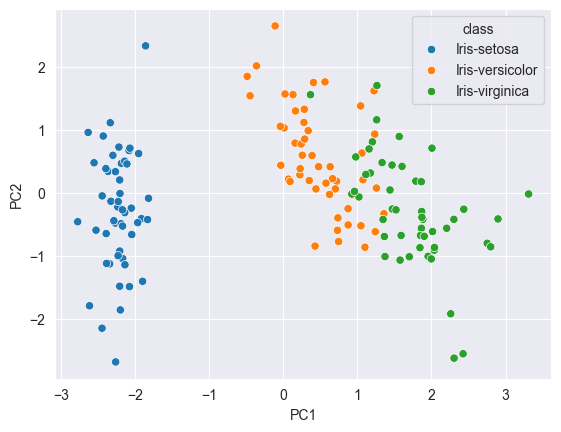

In [18]:
# Plot first 2 principal components
sns.scatterplot(x="PC1", y="PC2", hue="class", data=df_man);

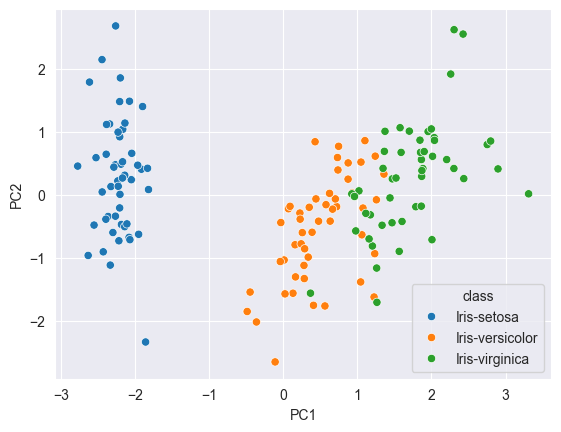

In [19]:
# Plot first 2 principal components
sns.scatterplot(x="PC1", y="PC2", hue="class", data=df);

Die händische Berechnung ist bis auf Spiegelung ident mit dem Ergebnis aus sklearn.

Abschließend betrachten wir noch den Plot der ersten Hauptkomponente:

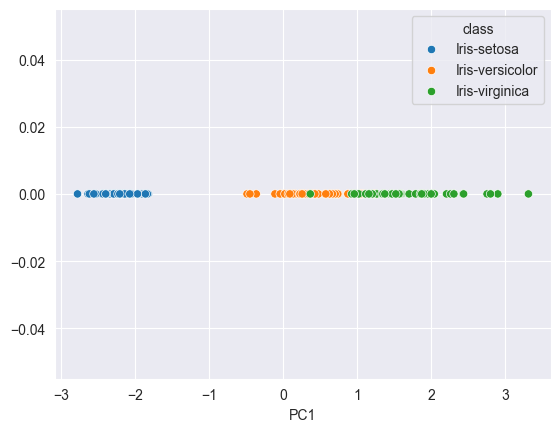

In [20]:
# First principal component
sns.scatterplot(x="PC1", y=[0]*len(df), hue="class", data=df);